In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'LICI.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-17,872.000000,918.950012,860.000000,875.250000,865.802368,48792877
2022-05-18,885.549988,891.000000,874.099976,876.349976,866.890564,8919761
2022-05-19,867.000000,867.000000,838.000000,840.849976,831.773743,7372427
2022-05-20,848.549988,856.799988,825.000000,826.150024,817.232422,7078291
2022-05-23,826.150024,852.700012,803.650024,816.849976,808.032776,12444648
...,...,...,...,...,...,...
2024-04-25,995.000000,995.200012,979.450012,984.500000,984.500000,1754417
2024-04-26,989.000000,1005.500000,982.000000,988.049988,988.049988,3359199
2024-04-29,994.000000,994.000000,977.599976,980.200012,980.200012,2000595


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
14/14 [==============================] - 16s 18ms/step - loss: 0.0414
Epoch 2/50
14/14 [==============================] - 0s 13ms/step - loss: 0.0088
Epoch 3/50
14/14 [==============================] - 0s 13ms/step - loss: 0.0074
Epoch 4/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0065
Epoch 5/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0066
Epoch 6/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 7/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 8/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 9/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 10/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 11/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 12/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0052
Epoch 13/50
14/14 [=================

1/1 [==============================] - 0s 22ms/step


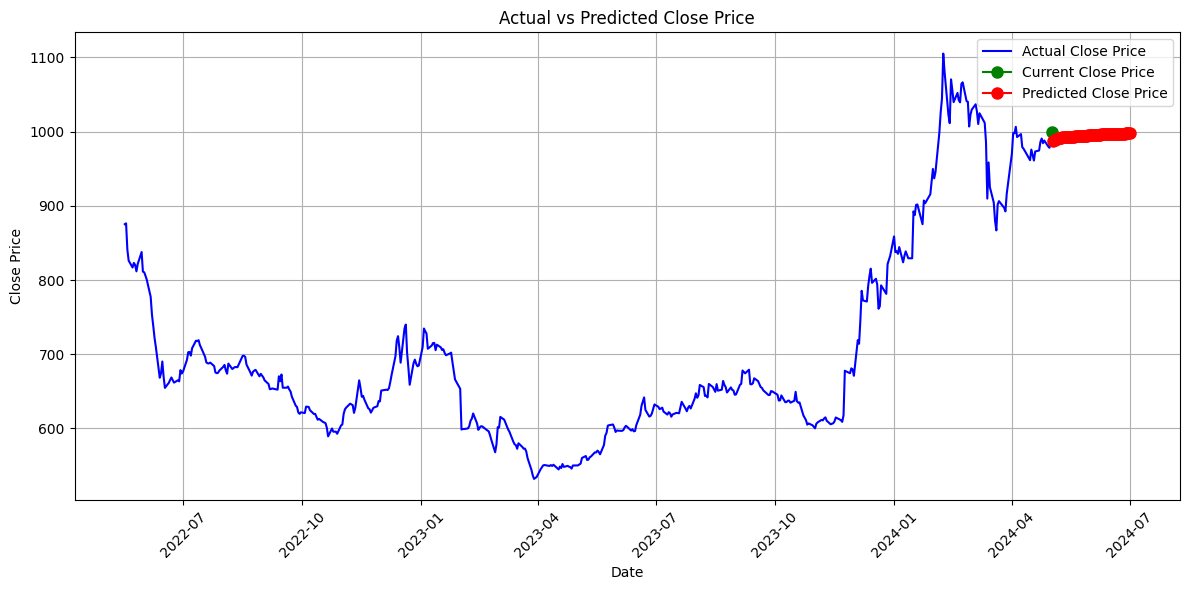

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([987.04675, 988.71326, 989.8924 , 990.6914 , 991.2383 , 991.6311 ,
       991.9313 , 992.1734 , 992.37616, 992.55023, 992.70245, 992.8389 ,
       992.9648 , 993.0843 , 993.2011 , 993.3181 , 993.4374 , 993.56024,
       993.68744, 993.819  , 993.9548 , 994.0941 , 994.2364 , 994.3807 ,
       994.5261 , 994.67175, 994.8167 , 994.9602 , 995.1015 , 995.2399 ,
       995.3748 , 995.506  , 995.633  , 995.75555, 995.8736 , 995.987  ,
       996.09576, 996.19995, 996.2997 , 996.395  , 996.4862 , 996.5733 ,
       996.6566 , 996.7364 , 996.8128 , 996.88605, 996.95624, 997.0237 ,
       997.08844, 997.15076, 997.21063, 997.2684 , 997.32404, 997.3776 ,
       997.4293 , 997.4792 , 997.52734, 997.5738 , 997.61865, 997.6619 ],
      dtype=float32)

In [10]:
model.save('LICI.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'LICI.pkl')

['LICI.pkl']